# We model the number of daily POI visits per user
### POIs as all venues in our data (visits not performed as work activity) are modeled in terms of:  
1. stringency (state covariate)  
2. death rate (state covariate)  
3. a seasonality term (accounting for 2 different weather conditions: humidity and temperature)
4. a temporal adaptation term (sigmoid shape depending on time)

In [16]:
import os
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def standardize(X):
    return (X-X.mean(0))/(X.std(0)+0.001)
def load_data(df,stand,logged, epidemiological_var):
    Y_data = df.metric.dropna().astype('float32')  # df.metric.rolling(7).mean().dropna()
    X1_data = df.StringencyIndex.loc[Y_data.index].fillna(0).astype('float32')
    X1_cumsum = df.loc[Y_data.index].groupby('state').StringencyIndex.cumsum().fillna(0).astype('float32')
    X2_data = df[epidemiological_var].loc[Y_data.index].fillna(0).astype('float32')
    X2_cumsum = df.loc[Y_data.index].groupby('state')[epidemiological_var].cumsum().fillna(0).astype('float32')
    X3_data = df.loc[Y_data.index].dayofyear.astype('float32')
    X4_data_hum = df.loc[Y_data.index].prec_weighted.astype('float32')
    X4_data_tem = df.loc[Y_data.index].temp_weighted.astype('float32')
    
    if logged: X2_data = np.log(1+X2_data)
        
    if stand:
        X1_data = standardize(X1_data)
        X2_data = standardize(X2_data)
        X4_data_hum = standardize(X4_data_hum)
        X4_data_tem = standardize(X4_data_tem)
    return (Y_data,X1_data,X1_cumsum,X2_data,X2_cumsum,X3_data,X4_data_hum,X4_data_tem,df.loc[Y_data.index].dow0,
            df.loc[Y_data.index].dow1,df.loc[Y_data.index].dow2,df.loc[Y_data.index].dow3,
            df.loc[Y_data.index].dow4,df.loc[Y_data.index].dow5,df.loc[Y_data.index].dow6, 
            df.loc[Y_data.index].weekday, pd.factorize(df.loc[Y_data.index].state)[0])

# pymc3_kwargs = {'target_accept':0.85}
def trace_models(model,sample=2500,tune=2500, chains=2, cores=2,tune_add_step=2500,iterations=1,max_iter=20,strong_convergence=False,pymc3_kwargs={}):
    if (iterations>max_iter):
        raise Exception(f'DivergencesError: Divergences after more than {max_iter} recursive calls! Try to reparametrize or increase tuning steps!')
    try:
        with model:  trace = pm.sample(sample, tune=tune, chains=chains, target_accept=0.9, **pymc3_kwargs)
        if strong_convergence == None: return trace
        elif (trace['diverging'].nonzero()[0].size==0): 
            if strong_convergence:
                if trace.report.ok: return trace
                else: return trace_models(model,sample,tune+tune_add_step,chains,cores,iterations = iterations+1)
            else: return trace
        else: return trace_models(model,sample,tune+tune_add_step,chains,cores,iterations = iterations+1)
    except: return trace_models(model,sample,tune+tune_add_step,chains,cores,iterations = iterations+1)


In [17]:
def define_models_v6(df,stand, logged, epidemiological_var, rho_state_mu, rho_state_sigma,
                     beta1_mu, beta1_sigma, beta2_mu, beta2_sigma,
                     rho_mu, rho_sigma, sigma_sigma,delta_mu, delta_sigma,
                     gamma1_sigma, gamma2_sigma, gamma3_mu, gamma3_sigma): 
    print("betas' sigma: ",beta1_sigma)
    Y_data,X1_data,X1_cumsum,X2_data,X2_cumsum,X3_data,X4_data_hum,X4_data_tem,Xrho0,Xrho1,Xrho2,Xrho3,Xrho4,Xrho5,Xrho6, weekday, state = load_data(df,stand,logged, epidemiological_var)
    
    weekend = (weekday >= 5).astype(int)

    ##############################################
    ####### Listing of all models tested #########
    ##############################################
# linear plus seasonality plus "aging" (aging with sigmoid) plus random effects for weekday
    
    with pm.Model() as season_random_plus_model:
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)
        
        gamma1 = pm.HalfNormal('gamma1', sigma=gamma1_sigma)
        gamma2_org = pm.HalfNormal('gamma2_org', sigma=gamma2_sigma,shape=4)
        gamma2 = pm.Deterministic('gamma2', gamma2_org + 0.01)
        gamma3_org = pm.HalfNormal('gamma3_org', sigma=gamma3_sigma, shape=4)
        gamma3 = pm.Deterministic('gamma3', gamma3_org+90)
        
        delta_hum = pm.Normal('delta_hum',mu=delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)
        
        X3_sigmoid = 1 / ( 1 + np.exp(-((gamma2[state]) * (X3_data.values - gamma3[state]))))
        if stand: 
            X3_sigmoid = standardize(X3_sigmoid)
        
        y_model = beta2 * X2_data.values + beta1 * X1_data.values  
        y_model += (gamma1) * X3_sigmoid
        
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)
    
# linear plus
    with pm.Model() as linear_random_plus_model:
        #rho_mu = pm.Normal('common_mu', mu=0., sd=1)
        #rho_sigma = pm.HalfCauchy('common_sd', 1)
        
        #alpha = pm.Normal('alpha',mu=alpha_mu,sigma=alpha_sigma)
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        y_model = beta2 * X2_data.values + beta1 * X1_data.values  
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)
    
# linear plus seasonality 
    with pm.Model() as sonly_random_plus_model:
        
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        delta_hum = pm.Normal('delta_hum',mu=delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)
        
        y_model = beta2 * X2_data.values + beta1 * X1_data.values
        y_model += delta_hum * X4_data_hum + delta_tem * X4_data_tem 
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)
        
# linear plus seasonality plus sigmoid in cumulated deaths per 100k inhabit.
    with pm.Model() as death_season_random_plus_model:
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        gamma1 = pm.HalfNormal('gamma1', sigma=gamma1_sigma)
        gamma2_org = pm.HalfNormal('gamma2_org', sigma=gamma2_sigma)
        gamma2 = pm.Deterministic('gamma2', gamma2_org + 0.01)
        gamma3_org = pm.HalfNormal('gamma3_org', sigma=gamma3_sigma)
        gamma3 = pm.Deterministic('gamma3', gamma3_org+90)

        delta_hum = pm.Normal('delta_hum',mu=delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)

        X3_sigmoid = 1 / ( 1 + np.exp(-((gamma2) * (X3_data.values - gamma3))))
        if stand: 
            X3_sigmoid = standardize(X3_sigmoid)
        
        y_model = beta1 * X1_data.values + beta2 * X2_data.values
        y_model += gamma1 * X3_sigmoid + delta_hum *X4_data_hum + delta_tem * X4_data_tem
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)

# linear plus seasonality plus sigmoid in cumulated regulations (stringency)
    with pm.Model() as strin_season_random_plus_model:
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        gamma1 = pm.HalfNormal('gamma1', sigma=gamma1_sigma)
        gamma2_org = pm.HalfNormal('gamma2_org', sigma=gamma2_sigma)
        gamma2 = pm.Deterministic('gamma2', gamma2_org/10 + 0.001)
        gamma3_org = pm.HalfNormal('gamma3_org', sigma=100)
        gamma3 = pm.Deterministic('gamma3', gamma3_org+100)

        delta_hum = pm.Normal('delta_hum',mu=delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)

        X3_sigmoid = 1 / ( 1 + np.exp(-((gamma2) * (X1_cumsum.values - gamma3))))
        if stand: X3_sigmoid = standardize(X3_sigmoid)
        
        y_model = beta1 * X1_data.values + beta2 * X2_data.values
        y_model += gamma1 * X3_sigmoid + delta_hum *X4_data_hum + delta_tem * X4_data_tem
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)

# linear plus seasonality plus quadratic in stringency.
    with pm.Model() as nl_sonly_random_plus_model:
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        beta11 = pm.Normal('beta11',mu=0,sigma=.1)

        delta_hum = pm.Normal('delta_hum',mu=delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)

        y_model = beta1 * X1_data.values + beta2 * X2_data.values
        y_model += delta_hum *X4_data_hum + delta_tem * X4_data_tem
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values) - rho[state].mean()
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)

# linear plus seasonality plus plus sigmoid in cumulated stringency (strin non linearity)
    with pm.Model() as nlsig_sonly_random_plus_model:
        beta1 = pm.Normal('beta1',mu=beta1_mu,sigma=beta1_sigma)
        beta2 = pm.Normal('beta2',mu=beta2_mu,sigma=beta2_sigma)
        rho = pm.Normal('rho_state', mu=rho_state_mu, sigma=rho_state_sigma, shape=4)
        rho0 = pm.Normal('rho0',mu=rho_mu,sigma=rho_sigma)
        rho1 = pm.Normal('rho1',mu=rho_mu,sigma=rho_sigma)
        rho2 = pm.Normal('rho2',mu=rho_mu,sigma=rho_sigma)
        rho3 = pm.Normal('rho3',mu=rho_mu,sigma=rho_sigma)
        rho4 = pm.Normal('rho4',mu=rho_mu,sigma=rho_sigma)
        rho5 = pm.Normal('rho5',mu=rho_mu,sigma=rho_sigma)
        rho6 = pm.Normal('rho6',mu=rho_mu,sigma=rho_sigma)
        sigma = pm.HalfNormal('sigma',sigma=sigma_sigma)

        # HAI CAMBIATO ANCHE IL SEGNO IN LINEA 300 (dove aggiungi termine sigmoide)
        gamma1 = pm.HalfNormal('gamma1', sigma=gamma1_sigma)
        gamma2_org = pm.HalfNormal('gamma2_org', sigma=gamma2_sigma,shape=4)
        gamma2 = pm.Deterministic('gamma2', gamma2_org + 0.01)
        gamma3_org = pm.HalfNormal('gamma3_org', sigma=gamma3_sigma, shape=4)
        gamma3 = pm.Deterministic('gamma3', gamma3_org+90)

        delta_hum = pm.Normal('delta_hum',mu=-delta_mu,sigma=delta_sigma)
        delta_tem = pm.Normal('delta_tem',mu=delta_mu,sigma=delta_sigma)

        X3_sigmoid = 1 / ( 1 + np.exp(-((gamma2[state]) * (X1_data.values - gamma3[state]))))
        if stand: X3_sigmoid = standardize(X3_sigmoid)
        
        y_model = beta1 * X1_data.values + beta2 * X2_data.values
        y_model += gamma1 * X3_sigmoid + delta_hum *X4_data_hum + delta_tem * X4_data_tem
        y_model += (rho0 * Xrho0.values + rho1 * Xrho1.values + rho2 * Xrho2.values + rho3 * Xrho3.values +rho4 * Xrho4.values + rho5 * Xrho5.values + rho6 * Xrho6.values)
        y_model += rho[state] - rho[state].mean()
        y = pm.StudentT('y',mu=y_model,sigma=sigma,nu=3,observed=Y_data.values)

    return {linear_random_plus_model:'linear_all',season_random_plus_model:'full_all',
            sonly_random_plus_model:'season_all',nlsig_sonly_random_plus_model:'strin_sig_season_all',
            death_season_random_plus_model:'death_full_all',strin_season_random_plus_model:'strin_full_all',
            nl_sonly_random_plus_model:'strin_square_season_all'}

In [18]:
save_path = f'./modeling_poi_mean_visits_traces/'

def resilient_sampling_v6(params,chains=2,cores=2,sample=5000,burn1=15000,burn=5000,strong_convergence=False,**kwargs):
    metric, logged, epi, name = params

    df = pd.read_csv(f'tab1_model_visits.csv',parse_dates=['date'])
    df[['dow0','dow1','dow2','dow3','dow4','dow5','dow6']] = df[['weekday']].reset_index().assign(new=1).pivot('index','weekday','new').fillna(0)

    conf = 'log_' if logged else ''
    conf += 'wd' if epi=='dailyDeathsPop' else 'wc'

    error = {}
    model_name = define_models_v6(df,stand=True,logged=logged,epidemiological_var=epi,**kwargs)
    models_dict = {item[1]:item[0] for item in model_name.items()}
    model = models_dict[name]
    if not os.path.exists(os.path.join(save_path,'all',name)):
        os.makedirs(os.path.join(save_path,'all',name))
    try:
        trace = trace_models(model,sample,burn1,chains,cores,strong_convergence=strong_convergence)
        pm.save_trace(trace,os.path.join(save_path,'all',name,f'{metric}_{conf}_samp{sample}_burn{burn}_std_v3.trace'),overwrite=True)
        return (trace,error)
    except Exception as e:
        print(e)
        if hasattr(e, 'message'): error = {'metric': metric,'logged':logged, 'epi_var':epi, 'model':name,'message':e.message}
        else:                     error = {'metric': metric,'logged':logged, 'epi_var':epi, 'model':name,'message':'Trace error'}
        return (None,error)

import arviz as az
def produce_stats(metric, models=['full_all','linear_all','season_all','strin_sig_season_all'],kwargs={},errorMethod='BB-pseudo-BMA',IC='loo',
                  logged=True,epi='dailyDeathsPop',stats=False,model_plot=True,sample = 5000,burn = 5000,ndraws=5000):
    ## LOAD MODELS AND TRACES
    df = pd.read_csv('tab1_model_visits.csv',parse_dates=['date'])
    df[['dow0','dow1','dow2','dow3','dow4','dow5','dow6']] = df[['weekday']].reset_index().assign(new=1).pivot('index','weekday','new').fillna(0)
    conf = 'log_' if logged else ''
    conf += 'wd' if epi=='dailyDeathsPop' else 'wc'

    ### Load traces and perform PSILOO model selection
    # Leave One Out cross-Validation
    tmp_res = pd.DataFrame()

    model_name = define_models_v6(df,stand=True,logged=logged,epidemiological_var=epi,**kwargs)
    models_dict = {item[1]:item[0] for item in model_name.items() if item[1] in models}
    traces = {}
    r2 = {}
    r2std = {}
    r2sem = {}
    preds = {}
    for name,model in models_dict.items():
        print(f'Loading traces... : Metric: {metric}  ->  Model: {name}')
        traces[name] = pm.load_trace(os.path.join(save_path,'all',name,f'{metric}_{conf}_samp{sample}_burn{burn}_std_v3.trace'),model=model)
        if stats:
            ppc = pm.sample_posterior_predictive(traces[name], samples=ndraws, model=model)
            r2[name],r2std[name] = az.r2_score(df.metric.dropna().values, ppc['y'])
            r2sem[name] = r2std[name]/np.sqrt(len(ppc['y'][0]))
            preds[name] = ppc
                
    if stats:
        results = az.compare(ic=IC,method=errorMethod,dataset_dict=traces)
        results['r2'] = pd.Series(r2).astype('float32')
        results['r2std'] = pd.Series(r2std).astype('float32')
        results['r2sem'] = pd.Series(r2sem).astype('float32')
        if model_plot:
            az.plot_compare(results,insample_dev=False)
            plt.title('All states',fontsize=14,fontweight='bold')
    
    if stats:
        results = results.reset_index().set_index(['index'])
#         tmp_res.to_csv(os.path.join(save_path,state,f'results_std_traces_s{sample}_b{burn}.csv'))
        return traces, results, preds
    else: 
        return traces, results, preds


### Running samplings

In [11]:
kwargs_all = {
    'rho_state_mu': 0, 'rho_state_sigma': 0.1, 'sigma_sigma'     : 0.01,
    'beta1_mu'        : -1, 'beta1_sigma'     : .1,
    'beta2_mu'        : -1, 'beta2_sigma'     : .1,
    'rho_mu'          : 0,  'rho_sigma'       : .05,

    'delta_mu'        : 0,  'delta_sigma'     : .1,
    'gamma1_sigma'    : .1, 'gamma2_sigma'    : .1,
    'gamma3_mu'       : 50, 'gamma3_sigma'    : 10
}

In [13]:
# Sampling traces!
import pymc3 as pm
import itertools

sample = 100
burn = 1000
chains=2
cores=2
epis = ['dailyDeathsPop']
logs = [True]

### For home measures we expect gamma2 to behave differently: -> gamma2 negative? (can we make this assumption?)
metrics = ['mean_visits']
names = ['full_all','strin_full_all', 'linear_all','season_all']
confs = list(itertools.product(metrics,logs,epis,names))

tvar_dict = {}
traces = {}
for i,config in enumerate(confs):
    params = config
    print(f'All_states - Model: {params[3]}\nMetric: {params[0]} - logged: {params[1]} - epi_var: {params[2]}')

    kwargs = kwargs_all
    tvar,errs = resilient_sampling_v6(params,chains=chains,cores=cores,sample=sample,burn1=burn,burn=burn,strong_convergence=None,**kwargs)
    tvar_dict[config] = tvar
#     break
if errs: print(errs)

All_states - Model: full_all
Metric: mean_visits - logged: True - epi_var: dailyDeathsPop
betas' sigma:  0.1


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_tem, delta_hum, gamma3_org, gamma2_org, gamma1, sigma, rho6, rho5, rho4, rho3, rho2, rho1, rho0, rho_state, beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2200/2200 [00:43<00:00, 51.01draws/s] 
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


All_states - Model: strin_full_all
Metric: mean_visits - logged: True - epi_var: dailyDeathsPop
betas' sigma:  0.1


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_tem, delta_hum, gamma3_org, gamma2_org, gamma1, sigma, rho6, rho5, rho4, rho3, rho2, rho1, rho0, rho_state, beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2200/2200 [00:31<00:00, 70.87draws/s] 


All_states - Model: linear_all
Metric: mean_visits - logged: True - epi_var: dailyDeathsPop
betas' sigma:  0.1


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, rho6, rho5, rho4, rho3, rho2, rho1, rho0, rho_state, beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2200/2200 [00:10<00:00, 200.71draws/s]


All_states - Model: season_all
Metric: mean_visits - logged: True - epi_var: dailyDeathsPop
betas' sigma:  0.1


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [delta_tem, delta_hum, sigma, rho6, rho5, rho4, rho3, rho2, rho1, rho0, rho_state, beta2, beta1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2200/2200 [00:14<00:00, 152.01draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


betas' sigma:  0.1


  0%|          | 32/20000 [00:00<01:02, 319.12it/s]

Loading traces... : Metric: mean_visits  ->  Model: linear_all


  0%|          | 1/20000 [00:00<47:31,  7.01it/s]

Loading traces... : Metric: mean_visits  ->  Model: full_all


  0%|          | 27/20000 [00:00<01:14, 268.61it/s]

Loading traces... : Metric: mean_visits  ->  Model: season_all


100%|██████████| 20000/20000 [00:23<00:00, 865.09it/s]


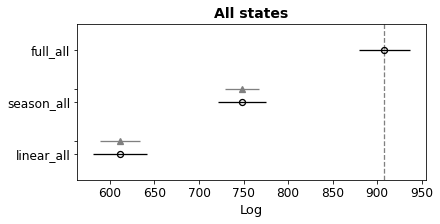

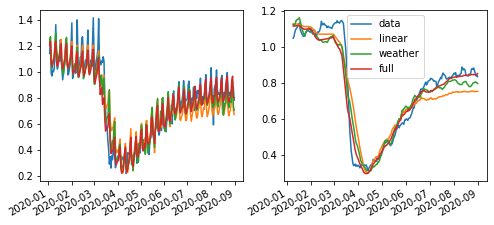

In [21]:
df = pd.read_csv('tab1_model_visits.csv',parse_dates=['date'])
df[['dow0','dow1','dow2','dow3','dow4','dow5','dow6']] = df[['weekday']].reset_index().assign(new=1).pivot('index','weekday','new').fillna(0)

metric = metrics[0]
t = tvar_dict
t[metric], stat, prediction = produce_stats(metric,models=['full_all','linear_all','season_all'],logged=True,epi='dailyDeathsPop',stats=True,model_plot=True,burn=burn,sample=sample,ndraws=20000,kwargs=kwargs,IC='loo')

predictions = {}
for d in [prediction]:
    for k, v in d.items():
        predictions[k] = v
        
Y_data,X1_data,X1_cumsum,X2_data,X2_cumsum,X3_data,X4_data_hum,X4_data_tem,Xrho0,Xrho1,Xrho2,Xrho3,Xrho4,Xrho5,Xrho6, weekday,state = load_data(df,stand=True,logged=True,epidemiological_var='dailyDeathsPop')
Y_lin = pd.Series(index=df.loc[Y_data.index]['date'], data=np.quantile(predictions['linear_all']['y'], 0.5, axis=0))
Y_compl = pd.Series(index=df.loc[Y_data.index]['date'], data=np.quantile(predictions['full_all']['y'], 0.5, axis=0))
Y_weather = pd.Series(index=df.loc[Y_data.index]['date'], data=np.quantile(predictions['season_all']['y'], 0.5, axis=0))
Y_data.index = Y_lin.index


fig,ax = plt.subplots(1,2,figsize=(8,3.5))
i=0

ax[0].plot(Y_data.iloc[i*242:(i+1)*242],label='data')
ax[0].plot(Y_lin.iloc[i*242:(i+1)*242],label='linear')
ax[0].plot(Y_weather.iloc[i*242:(i+1)*242],label='weather')
ax[0].plot(Y_compl.iloc[i*242:(i+1)*242],label='full')

ax[1].plot(Y_data.iloc[i*242:(i+1)*242].rolling(7).mean(),label='data')
ax[1].plot(Y_lin.iloc[i*242:(i+1)*242].rolling(7).mean(),label='linear')
ax[1].plot(Y_weather.iloc[i*242:(i+1)*242].rolling(7).mean(),label='weather')
ax[1].plot(Y_compl.iloc[i*242:(i+1)*242].rolling(7).mean(),label='full')

plt.legend()
fig.autofmt_xdate()

In [26]:
### For home measures we expect gamma2 to behave differently: -> gamma2 negative? (can we make this assumption?)
stats = pd.DataFrame()
temp_predictions = []
for metric in metrics:
    stat['metric'] = metric
    temp_predictions.append(prediction)
    if stats.empty: stats = stat.reset_index().set_index(['metric','index'])
    else:          stats = stats.append(stat.reset_index().set_index(['metric','index']))
        
stats = stats.iloc[np.invert(stats.index.duplicated(keep='last'))].reset_index().sort_values(['metric','rank']).set_index(['metric','index'])

stats['measure'] = stats.reset_index()['metric'].map({'mean_minutes_spent_per_stop':'duration of visits (hours)','no_home_mean_minutes_spent':'time away from home (hours)','mean_visits':'number of visits'}).values
export_tab = stats[['measure','loo','se','r2','r2std','weight']]
export_tab = export_tab.reset_index().rename(columns={'index':'model'}).set_index('model')
export_tab

,metric,measure,loo,se,r2,r2std,weight
model,,,,,,,
full_all,mean_visits,number of visits,908.177,28.5611,0.804239,0.016802,1
season_all,mean_visits,number of visits,748.302,26.6812,0.727215,0.023219,9.22596e-46
linear_all,mean_visits,number of visits,611.209,30.0596,0.672531,0.025823,2.9049e-103


In [29]:
for metric in metrics:
    # merge all the predictions
    predictions = {}
    for d in temp_predictions:
        for k, v in d.items():
            predictions[k] = v

    params2 = pd.DataFrame.from_dict({var:{'mean':t[metric]['full_all'][var].mean(),'std':t[metric]['full_all'][var].std()}
                                      for var in ['beta1','beta2','gamma1','delta_hum','delta_tem']}).T
    params2['model'] = 'full_all'
    params2.reset_index(inplace=True)
    params2.rename(columns={'index':'param'},inplace=True)
    params2 = params2.append(pd.DataFrame.from_records([(var,t[metric]['season_all'][var].mean(),t[metric]['season_all'][var].std(),'season_all') for var in ['beta1','beta2','delta_hum','delta_tem']],columns=['param','mean','std','model']),ignore_index=True)
    params2 = params2.append(pd.DataFrame.from_records([(var,t[metric]['linear_all'][var].mean(),t[metric]['linear_all'][var].std(),'linear_all') for var in ['beta1','beta2']],columns=['param','mean','std','model']),ignore_index=True)
    params2['var_name'] = params2['param'].map({'beta1':r'$\beta_{policy}$','beta2':r'$\beta_{deaths}$','delta_hum':r'$\beta_{rain}$','delta_tem':r'$\beta_{temp}$','gamma1':r'$\beta_{adapt}$'}).tolist()
    
params2

,param,mean,std,model,var_name
0,beta1,-0.249778,0.005522,full_all,$\beta_{policy}$
1,beta2,-0.038447,0.008188,full_all,$\beta_{deaths}$
2,gamma1,0.119080,0.004203,full_all,$\beta_{adapt}$
3,delta_hum,0.000334,0.097059,full_all,$\beta_{rain}$
4,delta_tem,0.005206,0.105318,full_all,$\beta_{temp}$
5,beta1,-0.205227,0.004622,season_all,$\beta_{policy}$
6,beta2,-0.052905,0.003422,season_all,$\beta_{deaths}$
7,delta_hum,-0.002995,0.003321,season_all,$\beta_{rain}$
8,delta_tem,0.091348,0.004524,season_all,$\beta_{temp}$
9,beta1,-0.148188,0.003944,linear_all,$\beta_{policy}$
